<a href="https://colab.research.google.com/github/NazmusShakib/melanoma-detection/blob/main/v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import PIL as pil
from PIL import Image
import cv2
from tqdm import tqdm
from keras import regularizers
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.metrics import Recall, categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import History, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [80]:
# check tensorflow version
tf.__version__

'2.12.0'

In [86]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [94]:
print(tf.test.is_built_with_cuda())

True


In [41]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/melanoma-detection/v2/'
SIZE = 28

In [42]:
raw_metadata = pd.read_csv(os.path.join(BASE_PATH,'HAM10000_metadata.csv'))

In [43]:
raw_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [44]:
raw_metadata.isna().isna().sum() # check for null items

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [45]:
raw_metadata.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [46]:
# label encoding to numeric values from text
label_encoder_obj = LabelEncoder()
label_encoder_obj.fit(raw_metadata['dx'])
print(list(label_encoder_obj.classes_))

raw_metadata['label'] = label_encoder_obj.transform(raw_metadata["dx"])
raw_metadata.sample(5)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,label
7806,HAM_0006078,ISIC_0032809,nv,histo,15.0,female,foot,5
5284,HAM_0004764,ISIC_0025270,nv,follow_up,60.0,male,abdomen,5
1149,HAM_0007410,ISIC_0031457,df,histo,65.0,male,foot,3
8837,HAM_0005894,ISIC_0025579,nv,histo,45.0,female,back,5
1070,HAM_0003691,ISIC_0027428,bkl,consensus,75.0,female,back,2


In [47]:
raw_metadata.label.unique()

array([2, 5, 3, 4, 6, 1, 0])

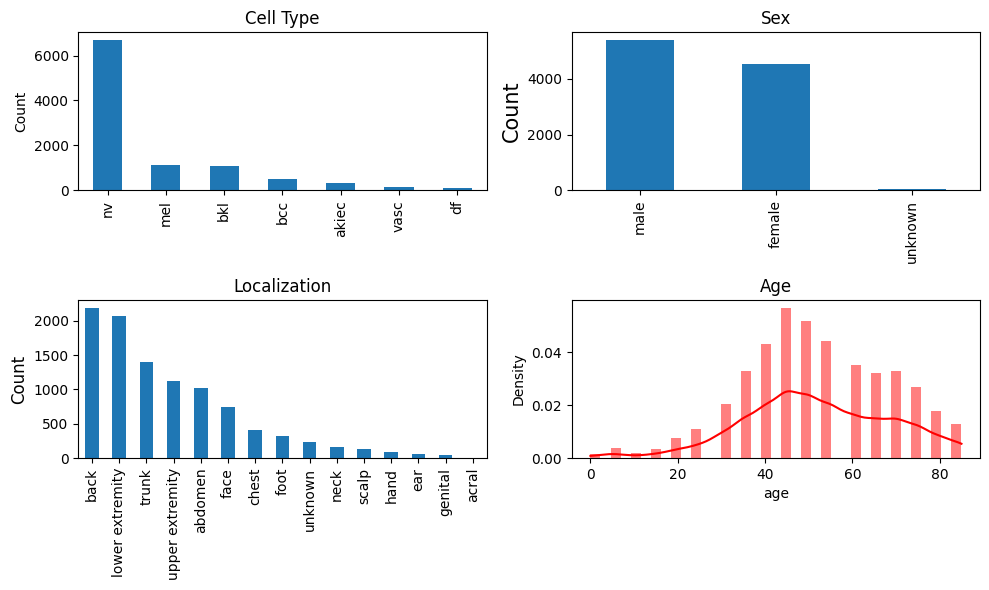

In [48]:
# Data distribution visualization
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,2,1)
raw_metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
raw_metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
raw_metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = raw_metadata[pd.notnull(raw_metadata['age'])]
sns.histplot(sample_age['age'], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [49]:
# Distribution of data into various classes
raw_metadata['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [50]:
raw_metadata['label'].value_counts()

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64

In [51]:
from sklearn.utils import resample
#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_label_0 = raw_metadata[raw_metadata['label'] == 0]
df_label_1 = raw_metadata[raw_metadata['label'] == 1]
df_label_2 = raw_metadata[raw_metadata['label'] == 2]
df_label_3 = raw_metadata[raw_metadata['label'] == 3]
df_label_4 = raw_metadata[raw_metadata['label'] == 4]
df_label_5 = raw_metadata[raw_metadata['label'] == 5]
df_label_6 = raw_metadata[raw_metadata['label'] == 6]

n_samples=1000
df_0_balanced = resample(df_label_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_label_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_label_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_label_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_label_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_label_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_label_6, replace=True, n_samples=n_samples, random_state=42)

In [52]:
#Combined back to a single dataframe
metadata_balanced = pd.concat([df_0_balanced, df_1_balanced,
                              df_2_balanced, df_3_balanced,
                              df_4_balanced, df_5_balanced, df_6_balanced])

In [53]:
metadata_balanced['label'].value_counts()

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
Name: label, dtype: int64

In [54]:
metadata_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0
...,...,...,...,...,...,...,...,...
2366,HAM_0006946,ISIC_0032614,vasc,histo,55.0,female,back,6
2330,HAM_0006617,ISIC_0028163,vasc,histo,25.0,female,abdomen,6
2449,HAM_0005427,ISIC_0028885,vasc,consensus,75.0,male,back,6
2438,HAM_0001780,ISIC_0024370,vasc,consensus,55.0,male,trunk,6


In [55]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(BASE_PATH + '/ham-10000/', '*', '*.jpg'))}

#Define the path and add as a new column
metadata_balanced['path'] = raw_metadata['image_id'].map(image_path.get)
#Use the path to read images.
metadata_balanced['image'] = metadata_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [56]:
metadata_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[154, 116, 104], [164, 128, 121], [175, 141,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[137, 75, 81], [132, 65, 71], [141, 77, 83],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[130, 93, 93], [182, 145, 144], [203, 166, 1..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[206, 149, 175], [209, 151, 171], [216, 162,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[202, 174, 198], [205, 174, 197], [204, 173,..."
...,...,...,...,...,...,...,...,...,...,...
2366,HAM_0006946,ISIC_0032614,vasc,histo,55.0,female,back,6,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[146, 109, 111], [152, 113, 115], [157, 118,..."
2330,HAM_0006617,ISIC_0028163,vasc,histo,25.0,female,abdomen,6,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[203, 173, 170], [204, 175, 169], [204, 175,..."
2449,HAM_0005427,ISIC_0028885,vasc,consensus,75.0,male,back,6,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[180, 88, 101], [186, 96, 108], [192, 106, 1..."
2438,HAM_0001780,ISIC_0024370,vasc,consensus,55.0,male,trunk,6,/content/drive/MyDrive/Colab Notebooks/melanom...,"[[[206, 133, 135], [207, 133, 135], [209, 133,..."


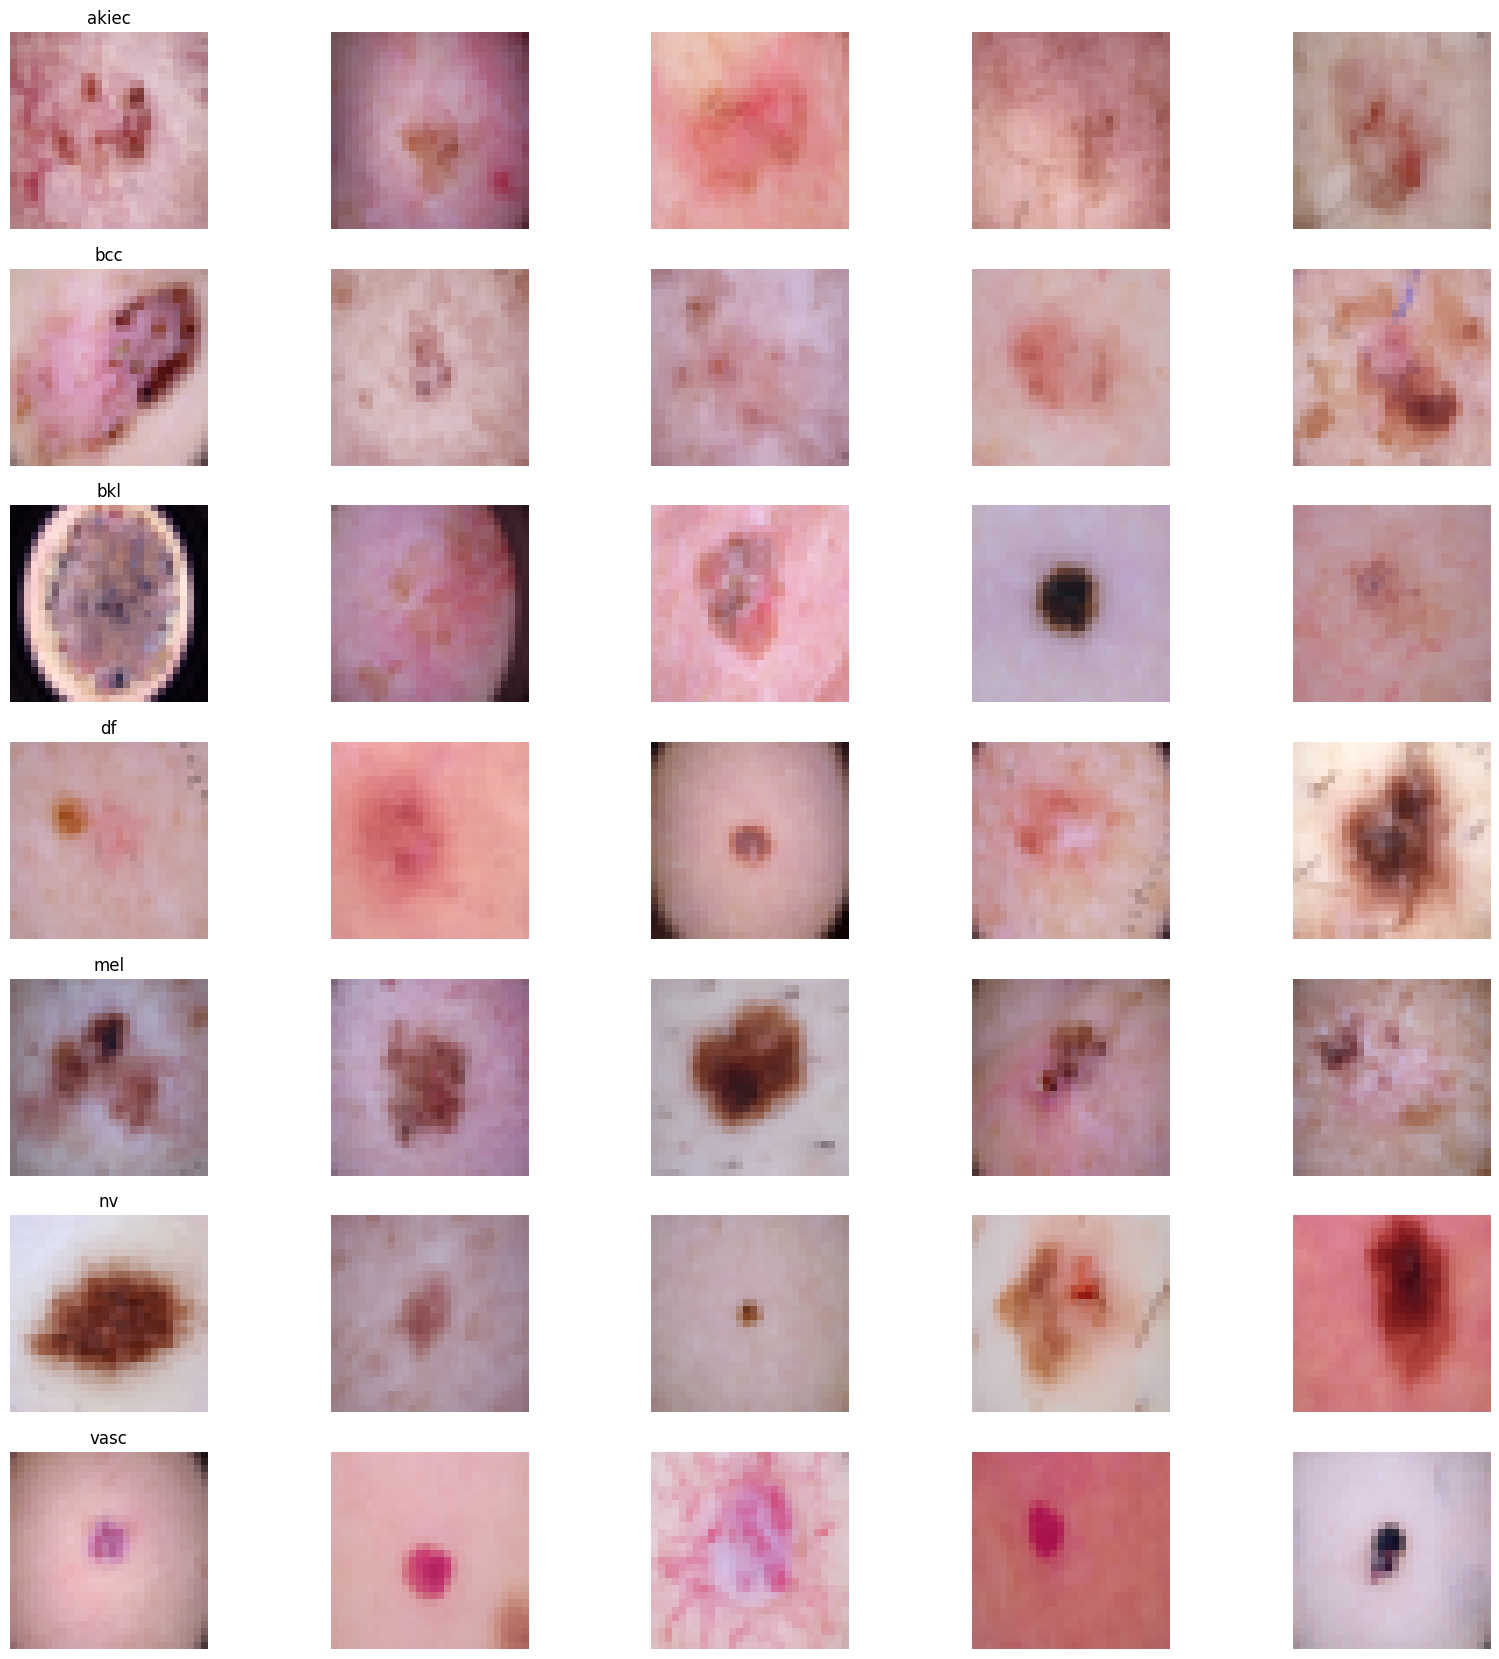

In [57]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, metadata_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

#Convert dataframe column of images into numpy array
X = np.asarray(metadata_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y = metadata_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [92]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

NUM_OF_CLASSES = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(NUM_OF_CLASSES, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 256)       7168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 128)       295040    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 128)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 64)         

In [93]:
# Train
# You can also use generator to use augmentation during training.
BATCH_SIZE = 16
EPOCHS = 100

history = model.fit(
    x_train, y_train,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (x_test, y_test),
    verbose = 2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/100
329/329 - 4s - loss: 1.7824 - acc: 0.2446 - val_loss: 1.5213 - val_acc: 0.3480 - 4s/epoch - 11ms/step
Epoch 2/100
329/329 - 2s - loss: 1.4826 - acc: 0.3987 - val_loss: 1.3789 - val_acc: 0.4389 - 2s/epoch - 7ms/step
Epoch 3/100
329/329 - 2s - loss: 1.3858 - acc: 0.4381 - val_loss: 1.3090 - val_acc: 0.4966 - 2s/epoch - 7ms/step
Epoch 4/100
329/329 - 2s - loss: 1.3229 - acc: 0.4804 - val_loss: 1.3102 - val_acc: 0.4509 - 2s/epoch - 5ms/step
Epoch 5/100
329/329 - 2s - loss: 1.2747 - acc: 0.4907 - val_loss: 1.2417 - val_acc: 0.5137 - 2s/epoch - 5ms/step
Epoch 6/100
329/329 - 2s - loss: 1.2271 - acc: 0.5170 - val_loss: 1.1700 - val_acc: 0.5583 - 2s/epoch - 5ms/step
Epoch 7/100
329/329 - 2s - loss: 1.1814 - acc: 0.5331 - val_loss: 1.1792 - val_acc: 0.5577 - 2s/epoch - 5ms/step
Epoch 8/100
329/329 - 2s - loss: 1.1589 - acc: 0.5444 - val_loss: 1.1324 - val_acc: 0.5566 - 2s/epoch - 5ms/step
Epoch 9/100
329/329 - 2s - loss: 1.1128 - acc: 0.5693 - val_loss: 1.1304 - val_acc: 0.5811 - 2s

In [95]:
# saving history
np.save(BASE_PATH + 'model_history_v2_1.npy', history.history)

# loading history
his = np.load(BASE_PATH + 'model_history_v2_1.npy',allow_pickle='TRUE').item()

In [96]:
model.save(BASE_PATH + 'model_v2_1.h5')
model.save_weights(BASE_PATH + 'model_v2_1.hdf5')  # Save weights

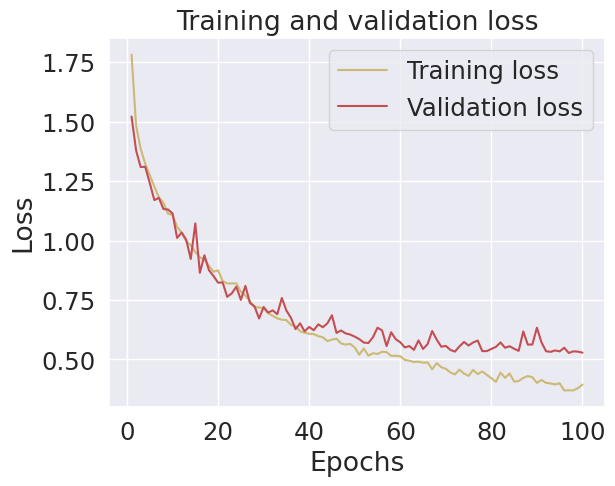

In [97]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

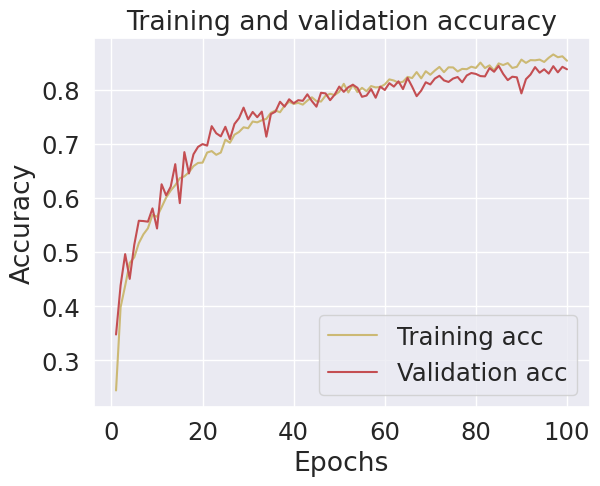

55/55 [==============================] - 0s 2ms/step


Text(32.25, 0.5, 'Fraction of incorrect predictions')

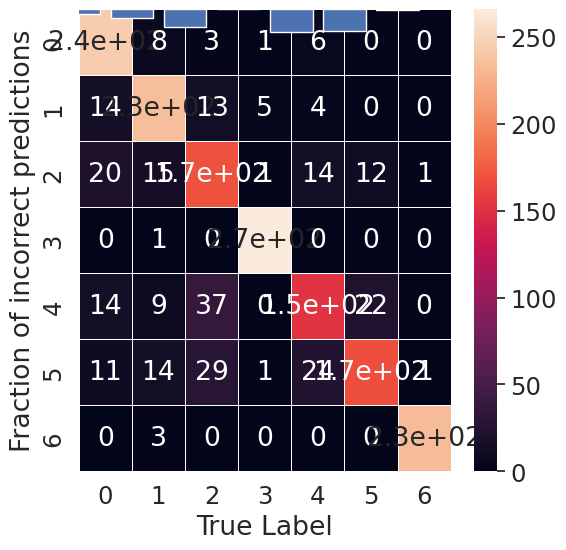

In [99]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')